# SAR Constant False Alarm Rate (CFAR) object detector in Julia 

## Object detection
 <a class="anchor" id="Introduction"></a>

This notebook illustrates how objects can be detected in Sentinel-1 SLC images using a CFAR approch. Two variants of the CFAR are implemented, the CP-CFAR and the CA-CFAR. 


Object detection are used in many fiels of earth observation in both the land and maritime enviroment. For the maritime enviroment, it is used in great extent for, e.g., iceberg detection or ship detection. 

SAR images contain pixel values with both an amplitude and a phase. Often, only the amplitude values are used for further analysis. The pixels in the the SAR bands correspond to physical values. It is ”straightforward” to analyse an image for a specific signature using some kind of threshold. One such threshold is the Constant False Alarm Rate (CFAR), applicable when one is looking for a specific intensity structure.

Often, object detection is used as a priliminary result whereafter the detected objects are classified as belonging to different classes.

## Table Of Contents
-  [Include modules](#Include)
-  [Load and show Image](#show_image)
-  [CFAR](#CFAR)
-  [CA-CFAR](#ca_cfar)
-  [CP-CFAR](#cp_cfar)
-  [Showing Objects in image](###show_objects)
-  [Location of objects](###Location_of_subsets)
-  [Extracting subsets of objects](###subsets)



## Include modules
 <a class="anchor" id="Include"></a>

The package is not relased yet. The code has to be cloned from github and instasiated to use before use. ThE package also contains 2 modules which are not included in the main script since they will be seperated to their own packages before release. 

In [1]:
include("../src/separateLater/Sentinel1/Sentinel1.jl");
include("../src/separateLater/VisualiseSAR/VisualiseSAR.jl");

using SARProcessing;

## Load and Show image
 <a class="anchor" id="show_image"></a>

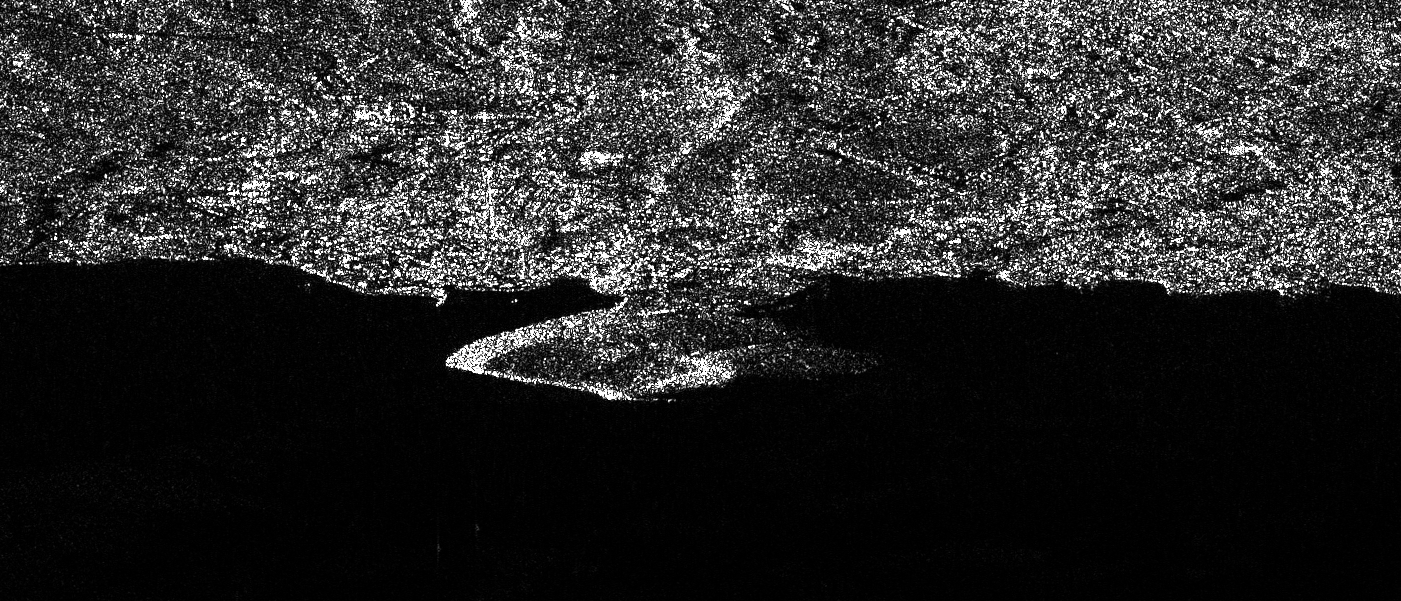

In [2]:
slcSubsetPath = "../test/testData/s1a-iw3-slc-vv_subset_hight9800_10400_width11000_11000.tiff";
complex_image = Sentinel1.readTiff(slcSubsetPath);
image = abs2.(complex_image);
VisualiseSAR.sar2grayimage(image, p_quantile = 0.95)

## CFAR
 <a class="anchor" id="CFAR"></a>

A simple CFAR is based on the histogram of the values within a kernel. A threshold value is then found as the X’th percentile value of the pixels within the kernel. Setting the CFAR at, e.g., the 0.99 percentile will result in a threshold that can discern very high values from low values, thus finding objects. The percentile value will stay constant for all regions defined by the moving kernel, but the threshold value itself will change.


![CFAR windows](figures/cfar_windows.png "CFAR windows")





The size of both the guard and background(clutter) windows must therefore be defined. Likewise should the probability for false alarms (PFA) 

In [3]:
background_window = 31; #pixels in image geometry
guard_window = 21; #pixels in image geometry
probability_for_alarms = 0.000000000001;

### CA-CFAR
 <a class="anchor" id="ca_cfar"></a>


A more advanced CA-CFAR utilises two parameters for finding objects and is explained in (Crisp, 2004). A so-called adaptive threshold algorithm using a background, a guard, and a target window is used. All three windows are applied on the entire image, one shifting pixel at a time. The Background window is used to calculate the statistics of the surrounding homogeneous area.

In [4]:
image_ca_cfar = SARProcessing.cell_averaging_constant_false_alarm_rate(image,background_window,guard_window,probability_for_alarms);

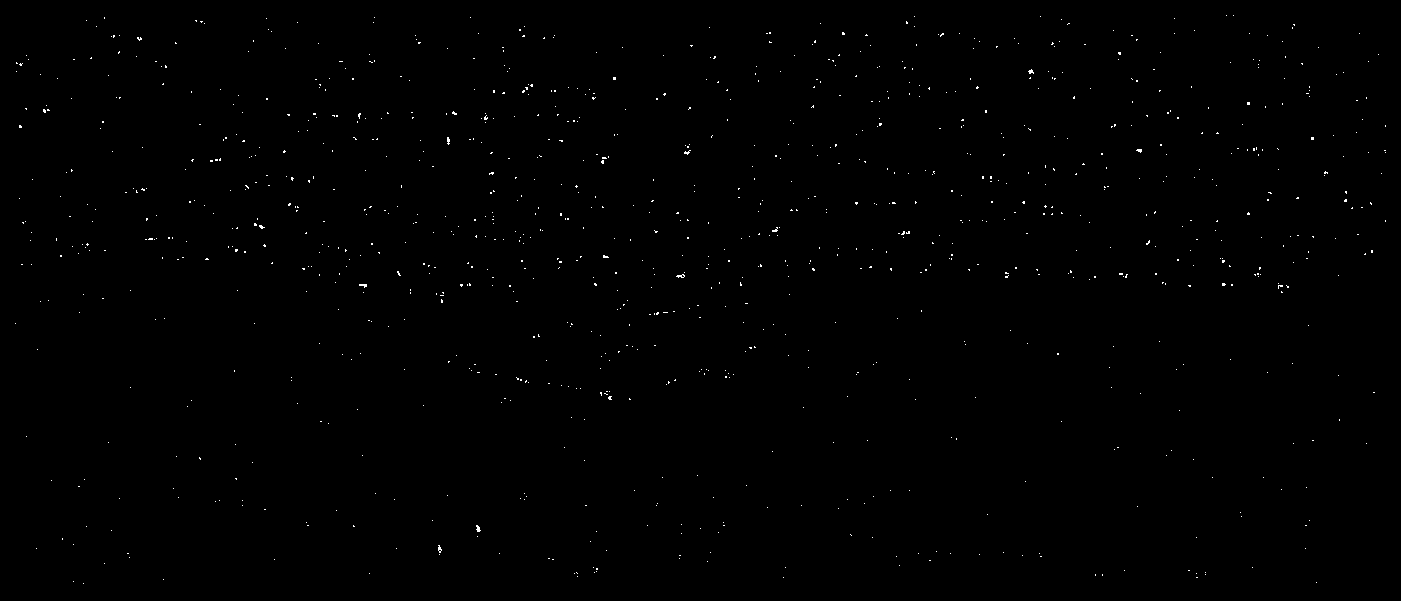

In [5]:
VisualiseSAR.sar2grayimage(image_ca_cfar, p_quantile = 0.95)

### CP-CFAR
<a class="anchor" id="cp_cfar"></a>

The CP-CFAR, described in *SAR Target CFAR Detection Via GPU Parallel Operation, Zongyong Cui et al, 2018,* utilizes morphological operations to reduve the number of false alarms and increase computation speed.


![CP-CFAR](figures/cp_cfar.png "CP-CFAR")

In [6]:
image_cp_cfar = SARProcessing.constant_false_alarm_rate_with_convolution_and_pooling(image,background_window ÷ 2,guard_window ÷ 2,probability_for_alarms);

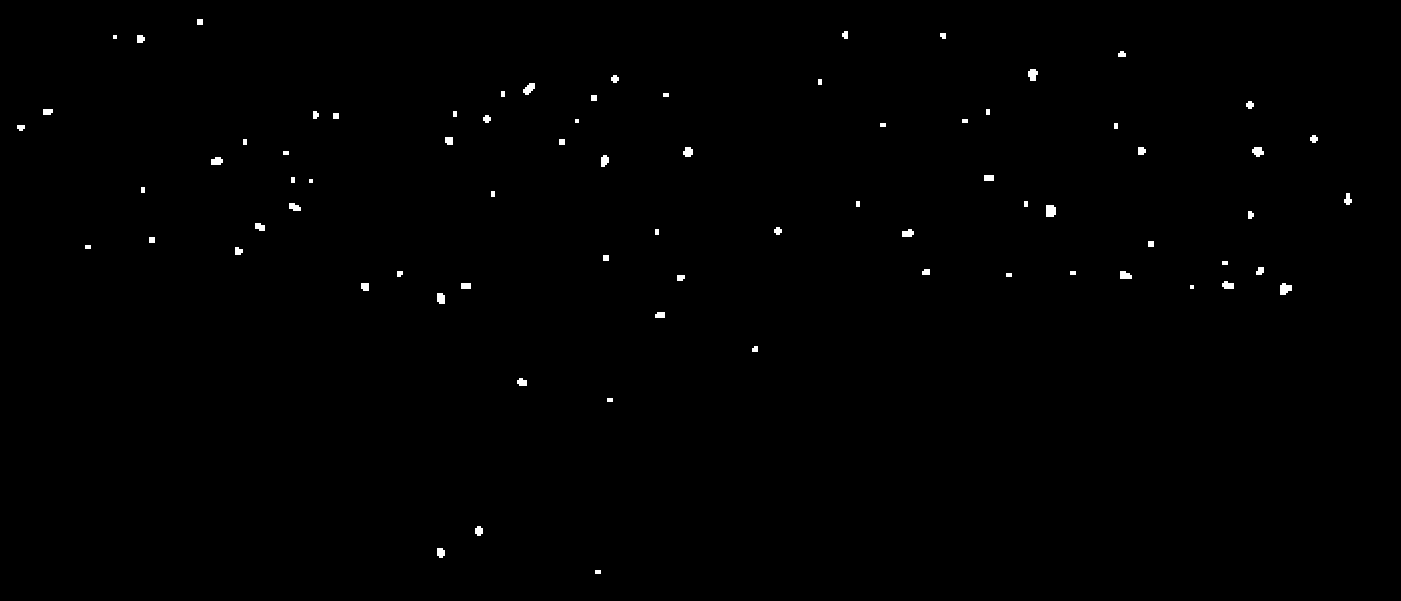

In [7]:
VisualiseSAR.sar2grayimage(image_cp_cfar, p_quantile = 0.95)

## Plotting objects in image
<a class="anchor" id="show_objects"></a>

Note, the following can only be plotting using the Plots package, not included in SARprocessing.jl.

In [11]:
using Plots

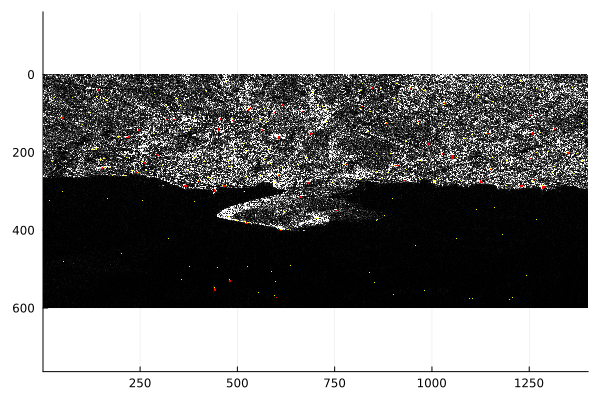

In [35]:
heatmap(VisualiseSAR.sar2grayimage(image, p_quantile = 0.95),legend = :none)
heatmap!(SARProcessing.mask_array_nan(convert.(Float64,image_ca_cfar)),color=:yellow,legend = :none)
heatmap!(SARProcessing.mask_array_nan(convert.(Float64,image_cp_cfar)),color=:red,legend = :none)

### Location of objects
<a class="anchor" id="Location_of_subsets"></a>

Finding the center of each object.

In [9]:
image_cp_cfar = SARProcessing.binarize_array(image_cp_cfar);
image_ca_cfar = SARProcessing.binarize_array(image_ca_cfar);

In [10]:
coord_cp = SARProcessing.object_locations(convert.(Float64,image_cp_cfar));
coord_ca = SARProcessing.object_locations(convert.(Float64,image_ca_cfar));

Illustrating the locations of the objects using CA-CFAR and CP-CFAR respectivly. 

In [ ]:
heatmap(VisualiseSAR.sar2grayimage(image, p_quantile = 0.95))
plot!(convert.(Float64,last.(coord_ca)),convert.(Float64,first.(coord_ca)), seriestype=:scatter, label="CA-CFAR objects", mc=:yellow, ms=2, ma=0.3)
plot!(convert.(Float64,last.(coord_cp)),convert.(Float64,first.(coord_cp)), seriestype=:scatter, label="CP-CFAR objects", mc=:red, ms=2, ma=0.5)


### getting subset of object

Extracting a subset of an object.

2-element Vector{Int64}:
  40
 141

In [25]:
index = findall(first.(coord_cp) .== maximum(first.(coord_cp)) );
coordinates = coord_cp[index][1]
coordinates2 = coord_cp[5]
subset = SARProcessing.get_subset(image,coordinates ,[45,45]);
subset2 = SARProcessing.get_subset(image,coordinates2 ,[45,45]);

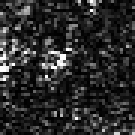

In [26]:
VisualiseSAR.sar2grayimage(subset[:,:,1], p_quantile = 0.99)


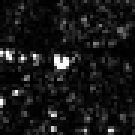

In [27]:
VisualiseSAR.sar2grayimage(subset2[:,:,1], p_quantile = 0.99)